In [6]:
from google.colab import files
uploaded = files.upload()

Saving yoga_train.txt to yoga_train.txt


In [7]:
import os
import pandas as pd
import re

In [8]:
with open("yoga_train.txt", "r") as file:
    data = file.readlines()
    print(data[:5])  # Preview the first 5 lines

['Akarna_Dhanurasana/64.jpg,1,8,0\n', 'Akarna_Dhanurasana/229.jpg,1,8,0\n', 'Akarna_Dhanurasana/128.jpg,1,8,0\n', 'Akarna_Dhanurasana/145.jpg,1,8,0\n', 'Akarna_Dhanurasana/47.jpg,1,8,0\n']


In [9]:
df = pd.DataFrame(data, columns=["text"])
# Split the 'text' column using the delimiter pattern
df[['image_path', 'keypoints', 'label','extra_field']] = df['text'].str.split(r',(?=\S)|$', expand=True, n=3)
# Drop the original 'text' column
df = df.drop('text', axis=1)

In [10]:
df.head()

,image_path,keypoints,label,extra_field
0,Akarna_Dhanurasana/64.jpg,1,8,0\n
1,Akarna_Dhanurasana/229.jpg,1,8,0\n
2,Akarna_Dhanurasana/128.jpg,1,8,0\n
3,Akarna_Dhanurasana/145.jpg,1,8,0\n
4,Akarna_Dhanurasana/47.jpg,1,8,0\n


In [11]:
#data Preprocess
df['keypoints'] = df['keypoints'].astype(str) + ',' + df['label'].astype(str)
print(df.head())


                   image_path keypoints label extra_field
0   Akarna_Dhanurasana/64.jpg       1,8     8         0\n
1  Akarna_Dhanurasana/229.jpg       1,8     8         0\n
2  Akarna_Dhanurasana/128.jpg       1,8     8         0\n
3  Akarna_Dhanurasana/145.jpg       1,8     8         0\n
4   Akarna_Dhanurasana/47.jpg       1,8     8         0\n


In [12]:
df =df.drop('label', axis=1)
df.head()

,image_path,keypoints,extra_field
0,Akarna_Dhanurasana/64.jpg,"1,8",0\n
1,Akarna_Dhanurasana/229.jpg,"1,8",0\n
2,Akarna_Dhanurasana/128.jpg,"1,8",0\n
3,Akarna_Dhanurasana/145.jpg,"1,8",0\n
4,Akarna_Dhanurasana/47.jpg,"1,8",0\n


In [13]:
#convert the keypoints column to a list of numeric values
df["keypoints"] = df["keypoints"].apply(lambda x: list(map(float, x.split(","))))
print(df["keypoints"].head())

0    [1.0, 8.0]
1    [1.0, 8.0]
2    [1.0, 8.0]
3    [1.0, 8.0]
4    [1.0, 8.0]
Name: keypoints, dtype: object


**Pose Detection Framework**

In [14]:
!pip install mediapipe==0.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [15]:
import cv2
import mediapipe as mp
import numpy as np

In [16]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [17]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Example function for pose detection
def detect_pose(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    return results.pose_landmarks


In [18]:
# Function to calculate the angle between three points
def calculate_angle(a, b, c):
    """
    Calculate the angle (in degrees) between points a, b, and c.
    a, b, and c should be lists or arrays of two coordinates [x, y].
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    # Calculate the vectors
    ba = a - b
    bc = c - b

    # Calculate the cosine of the angle
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))

    # Ensure the value is within the valid range [-1, 1] to avoid NaN errors
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)

    # Convert cosine to angle in degrees
    angle = np.degrees(np.arccos(cosine_angle))
    return angle

In [19]:
# Example: Pose correction
def correct_pose(keypoints, ideal_angles):
    """
    Compare detected keypoints with ideal pose keypoints and provide feedback.

    keypoints: List of keypoints [[x1, y1], [x2, y2], ...].
    ideal_angles: Dictionary with key joint names and values as ideal angles.
    """
    feedback = {}
    for joint_name, (a_idx, b_idx, c_idx, ideal_angle) in ideal_angles.items():
        # Get the keypoints for the joint
        a = keypoints[a_idx]
        b = keypoints[b_idx]
        c = keypoints[c_idx]

        # Calculate the detected angle
        detected_angle = calculate_angle(a, b, c)

        # Check if the angle is within the acceptable range
        if abs(detected_angle - ideal_angle) > 5:  # Allowable deviation
            feedback[joint_name] = f"Adjust your {joint_name} position! Current angle: {detected_angle:.2f}°"
        else:
            feedback[joint_name] = f"{joint_name} is correct. Angle: {detected_angle:.2f}°"
    return feedback

In [20]:
# Example keypoints (detected pose)
keypoints = [
    [1.0, 8.0],  # Point 0
    [2.0, 6.0],  # Point 1
    [3.0, 4.0],  # Point 2
    [4.0, 2.0],  # Point 3
]

# Define ideal angles for specific joints
# Format: "Joint Name": (index_a, index_b, index_c, ideal_angle_in_degrees)
ideal_angles = {
    "Left Elbow": (0, 1, 2, 90),
    "Right Knee": (1, 2, 3, 120),
}

# Run pose correction
feedback = correct_pose(keypoints, ideal_angles)
# Print feedback
for joint, message in feedback.items():
    print(message)

Adjust your Left Elbow position! Current angle: 180.00°
Adjust your Right Knee position! Current angle: 180.00°


In [21]:
def calculate_pck(detected_keypoints, ground_truth_keypoints, threshold=0.05):
    correct = 0
    total = len(ground_truth_keypoints)
    for detected, truth in zip(detected_keypoints, ground_truth_keypoints):
        distance = np.linalg.norm(np.array(detected) - np.array(truth))
        if distance <= threshold:
            correct += 1
    return correct / total
# Example usage:
detected_keypoints = [[[100, 150], [200, 250]], [[110, 160], [210, 260]]]  # Keypoints for multiple images
ground_truth_keypoints = [[[102, 153], [198, 252]], [[108, 158], [205, 255]]]  # Ground truth for those images

accuracy = calculate_pck(detected_keypoints, ground_truth_keypoints, threshold=5)
print(f"Overall accuracy (PCK): {accuracy}")

Overall accuracy (PCK): 0.5


In [27]:
import cv2
import matplotlib.pyplot as plt
# Visualize the pose


In [22]:
from google.colab import files
uploaded = files.upload()

Saving yoga_pose.jpg to yoga_pose.jpg


In [28]:
from PIL import Image

image = Image.open('yoga_pose.jpg').convert('RGB')
image = np.array(image)

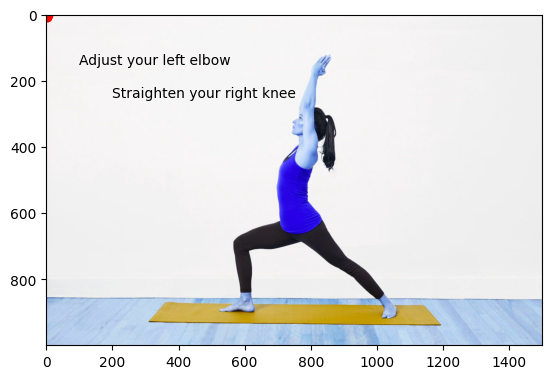

In [29]:
import matplotlib.pyplot as plt

def visualize_pose(image, keypoints, corrections):
    plt.imshow(image)
    for point in keypoints:
        plt.scatter(point[0], point[1], c='red')
    for correction in corrections:
        plt.annotate(correction['message'], (correction['x'], correction['y']))
    plt.show()
corrections = [
    {'message': 'Adjust your left elbow', 'x': 100, 'y': 150},
    {'message': 'Straighten your right knee', 'x': 200, 'y': 250},
]

image = cv2.imread('yoga_pose.jpg')
visualize_pose(image, keypoints, corrections)